# Gneral install and imports

In [1]:
pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 4.3 MB/s 


In [2]:
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Generate Series (e.g. 2)

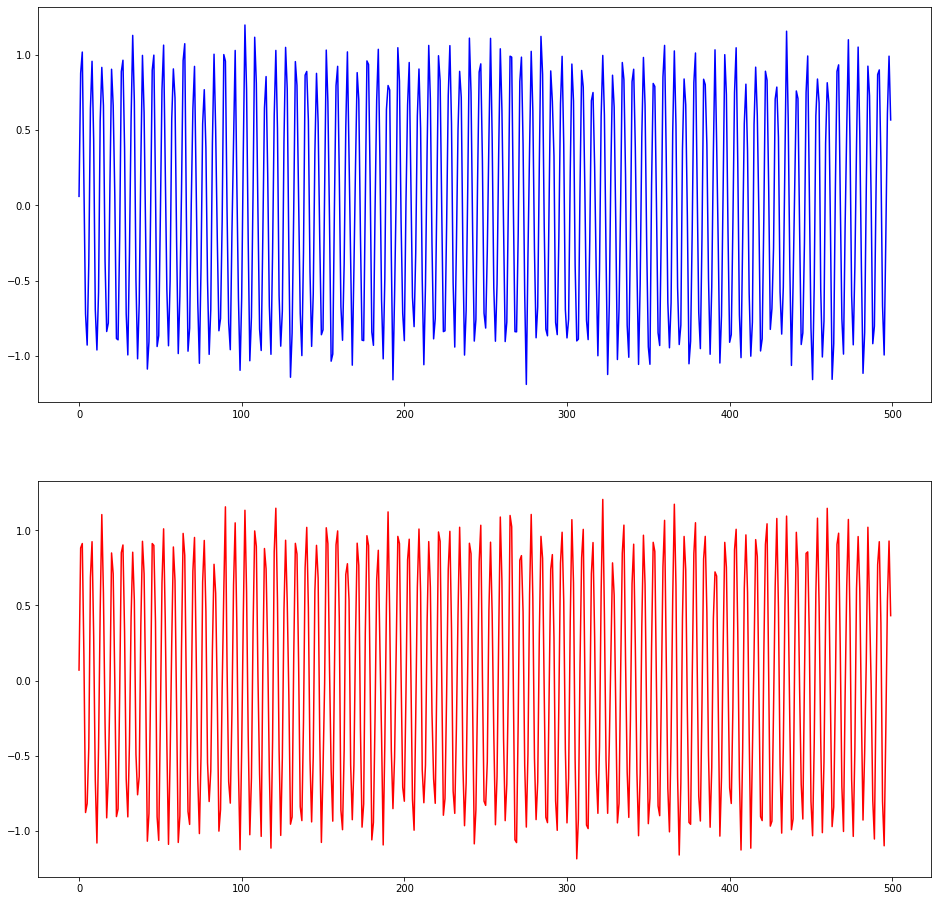

In [3]:
num_data = 500
rng_key = random.PRNGKey(12)
seed1, seed2 = random.split(rng_key, 2)
t = jnp.arange(0, num_data)
y_1 = jnp.sin(t) + random.normal(seed1, (num_data,)) * 0.1
y_2 = jnp.sin(t) + random.normal(seed2, (num_data,)) * 0.1
fig,axes=plt.subplots(2, figsize=(16, 16))
ax1=axes[0]
ax2=axes[1]
ax1.plot(y_1,'b')
ax2.plot(y_2, 'r')

In [4]:
series = jnp.vstack((y_1, y_2))
series 

DeviceArray([[ 0.06050494,  0.8803069 ,  1.0203824 ,  0.16407159,
              -0.72083914, -0.9286778 , -0.38424474,  0.64378184,
               0.9588607 ,  0.43636656, -0.69329506, -0.96132874,
              -0.57680607,  0.561931  ,  0.9183845 ,  0.6658945 ,
              -0.36933124, -0.8384142 , -0.7821715 ,  0.13543506,
               0.9061177 ,  0.66443586,  0.06311134, -0.8853283 ,
              -0.89371526, -0.2045353 ,  0.8909669 ,  0.96618956,
               0.38219404, -0.7200733 , -0.99417394, -0.32143426,
               0.5683389 ,  1.1313117 ,  0.6935959 , -0.49700052,
              -1.0200835 , -0.64932495,  0.28325924,  0.99820876,
               0.61830485, -0.22243837, -1.0883739 , -0.9053527 ,
              -0.04871309,  0.89948326,  0.99998343,  0.12117911,
              -0.9382532 , -0.86654747, -0.07568215,  0.77224046,
               1.0664977 ,  0.2516063 , -0.56058645, -0.93320084,
              -0.50403   ,  0.5748869 ,  0.9083878 ,  0.71614254,
          

# MCMC settings

In [5]:
mcmc_kwargs = dict(num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(12)
seed1, seed2, seed3 = random.split(rng_key, 3)

# Complete Pooling

In [81]:
def Complete_Pooling(y, train_size, future = 0):
  
  new_y = y.reshape(y.shape[0] * y.shape[1])[ :train_size]
  
  alpha_1 = numpyro.sample('alpha_1', dist.Normal(0, 1))
  alpha_2 = numpyro.sample('alpha_2', dist.Normal(0, 1))
  const = numpyro.sample("const", dist.Normal(0, 1))
  sigma = numpyro.sample("sigma", dist.HalfNormal(1))

  def transition(carry,_):
      y_prev, y_prev_prev = carry
      m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
      y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
      carry = (y_t, y_prev)
      return carry, y_t

  T = new_y.shape[0] - 2
  init = (new_y[1], new_y[0])

  with numpyro.handlers.condition(data={"y": new_y[2:]}): _, y_t = scan(transition, init, jnp.arange(T + future))
        

  if future > 0:
    numpyro.deterministic('y_forecast', y_t[-future:])

In [82]:
complete_pooling_mcmc = MCMC(NUTS(Complete_Pooling), **mcmc_kwargs)
complete_pooling_mcmc.run(seed1, series, 980)

sample: 100%|██████████| 4000/4000 [00:10<00:00, 372.56it/s, 7 steps of size 5.93e-01. acc. prob=0.93]


In [83]:
complete_pooling_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      1.04      0.01      1.04      1.02      1.05   1916.31      1.00
   alpha_2     -0.95      0.01     -0.95     -0.97     -0.94   1623.29      1.00
     const      0.00      0.01      0.00     -0.01      0.01   2205.90      1.00
     sigma      0.18      0.00      0.18      0.17      0.19   2017.56      1.00

Number of divergences: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb73e24ccd0>,
      dtype=object)

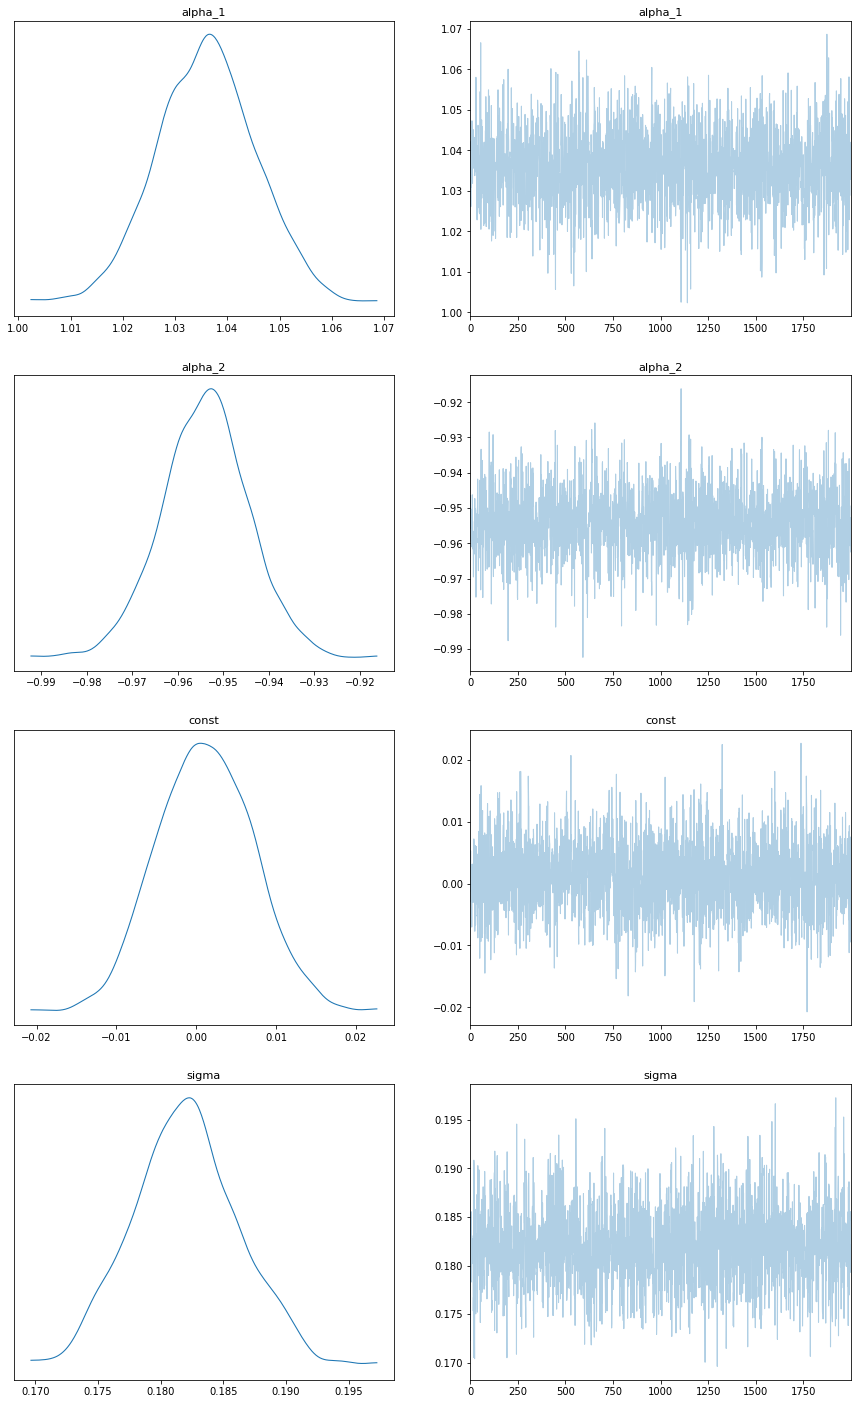

In [84]:
data_complete = az.from_numpyro(complete_pooling_mcmc)
az.plot_trace(data_complete, compact=True, figsize=(15, 25))

In [85]:
posterior_samples_complete = complete_pooling_mcmc.get_samples()
predictive_complete = Predictive(Complete_Pooling, posterior_samples_complete, return_sites=['y_forecast'])
preds_complete = predictive_complete(seed1, series, 980, 20)

In [86]:
preds_complete['y_forecast'].shape

(2000, 20)

In [87]:
mean_preds_complete = preds_complete['y_forecast'].T.mean(axis = 1)
mean_preds_complete.shape

(20,)

In [88]:
std_preds_complete = preds_complete['y_forecast'].T.std(axis = 1)
std_preds_complete.shape

(20,)

In [89]:
upper_complete = mean_preds_complete + std_preds_complete
lower_complete = mean_preds_complete - std_preds_complete

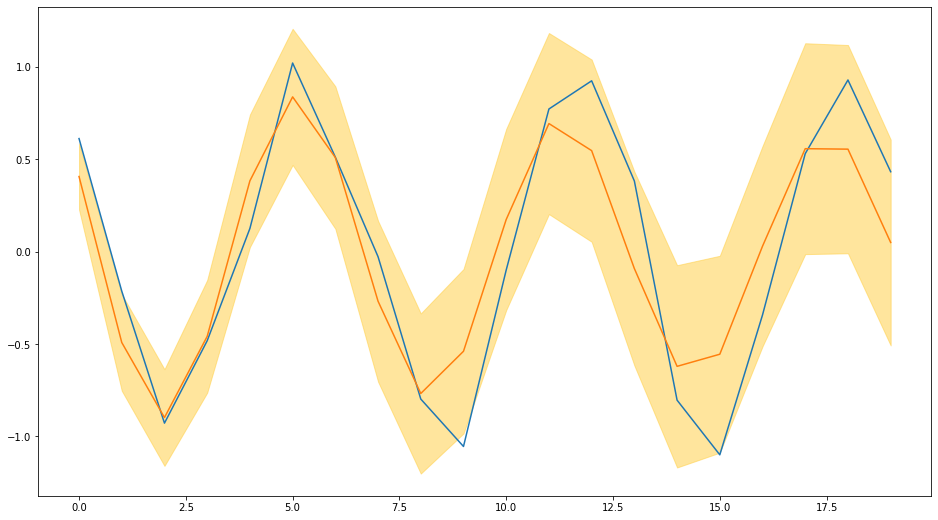

In [102]:
plt.figure(figsize=(16,9))
plt.plot(jnp.arange(0,20), series.reshape(series.shape[0] * series.shape[1])[980:])
plt.plot(jnp.arange(0,20), mean_preds_complete)
plt.fill_between(jnp.arange(0,20),upper_complete, lower_complete, alpha=0.5, color="#ffcd3c")

# No Pooling

In [68]:
train_series = jnp.vstack((series[0][:480], series[1][:480]))

480

In [93]:
def No_Pooling(y, future = 0):
  
  number = y.shape[0]

  with numpyro.plate('number', number):
    alpha_1 = numpyro.sample('alpha_1', dist.Normal(0, 1))
    alpha_2 = numpyro.sample('alpha_2', dist.Normal(0, 1))
    const = numpyro.sample("const", dist.Normal(0, 1))
  
  sigma = numpyro.sample("sigma", dist.HalfNormal(1))

  for i in range(number):
    def transition(carry,_):
      y_prev, y_prev_prev = carry
      m_t = const[i] + alpha_1[i] * y_prev + alpha_2[i] * y_prev_prev
      y_t = numpyro.sample("y_{}".format(i), dist.Normal(m_t, sigma))
      carry = (y_t, y_prev)
      return carry, y_t
    T = len(y[i]) - 2
    init = (y[i][1], y[i][0])
    with numpyro.handlers.condition(data={"y": y[i][2:]}): _, y_t = scan(transition, init, jnp.arange(T + future))
    
    if future > 0:
      numpyro.deterministic('y_forecast_{}'.format(i), y_t[-future:])  

  


In [94]:
no_pooling_mcmc = MCMC(NUTS(No_Pooling), **mcmc_kwargs)
no_pooling_mcmc.run(seed2, train_series)

sample: 100%|██████████| 4000/4000 [01:27<00:00, 45.84it/s, 1023 steps of size 1.78e-02. acc. prob=0.86]


In [ ]:
no_pooling_mcmc.print_summary()

In [95]:
posterior_samples_no = no_pooling_mcmc.get_samples()
predictive_no = Predictive(No_Pooling, posterior_samples_no)
preds_no = predictive_no(seed2, series, 20)
preds_no

{'y_forecast_0': DeviceArray([[ 2.3605006 ,  2.003323  ,  1.5344497 , ...,  1.2944261 ,
                1.9099376 ,  1.0601209 ],
              [-0.40199882, -0.9510827 , -0.81526816, ...,  1.5959423 ,
                1.9432559 ,  2.5904598 ],
              [ 0.4729117 ,  1.160986  , -0.553965  , ...,  1.2857319 ,
                1.2698821 ,  0.7297922 ],
              ...,
              [ 0.2544897 ,  0.16050895,  1.8601694 , ..., -0.07013255,
                0.40972847,  1.2014188 ],
              [ 1.0256802 ,  1.4593928 ,  0.7433512 , ...,  0.54178566,
                1.6624367 ,  0.06470127],
              [ 0.78867966,  0.32598743,  1.9692043 , ...,  0.6428246 ,
                1.1733304 ,  1.5775931 ]], dtype=float32),
 'y_forecast_1': DeviceArray([[-0.14779253, -1.5669713 ,  0.7453722 , ..., -0.18377392,
               -0.44768777, -0.28933483],
              [-0.4606073 , -0.3348643 , -1.0847253 , ..., -0.6144271 ,
                0.465162  , -0.78682894],
              [-0.44

In [96]:
mean_preds_no_0 = preds_no['y_forecast_0'].T.mean(axis = 1)
mean_preds_no_0.shape

(20,)

In [97]:
std_preds_no_0 = preds_no['y_forecast_0'].T.std(axis = 1)
std_preds_no_0.shape

(20,)

In [98]:
upper_no_0 = mean_preds_no_0 + std_preds_no_0
lower_no_0 = mean_preds_no_0 - std_preds_no_0

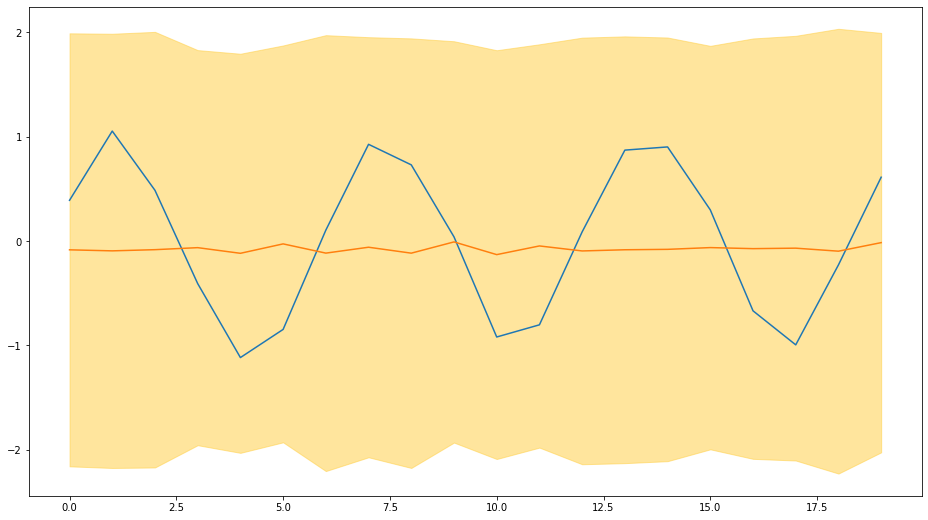

In [100]:
plt.figure(figsize=(16,9))
plt.plot(jnp.arange(0,20), series[0][478:498])
plt.plot(jnp.arange(0,20), mean_preds_no_0)
plt.fill_between(jnp.arange(0,20),upper_no_0, lower_no_0, alpha=0.5, color="#ffcd3c")

In [79]:
mean_preds_no_1 = preds_no['y_forecast_1'].T.mean(axis = 1)
std_preds_no_1 = preds_no['y_forecast_1'].T.std(axis = 1)
upper_no_1 = mean_preds_no_1 + std_preds_no_1
lower_no_1 = mean_preds_no_1 - std_preds_no_1

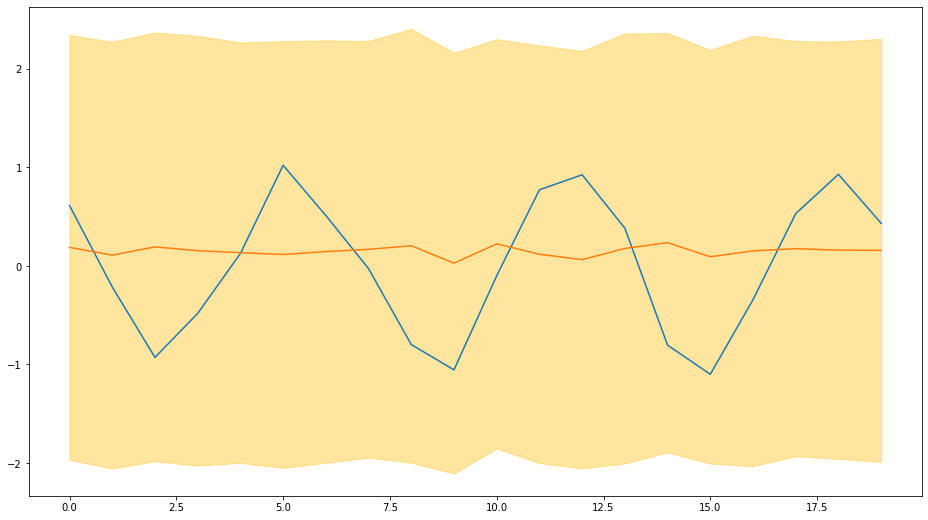

In [80]:
plt.figure(figsize=(16,9))
plt.plot(jnp.arange(0,20), series[1][480:])
plt.plot(jnp.arange(0,20), mean_preds_no_1)
plt.fill_between(jnp.arange(0,20),upper_no_1, lower_no_1, alpha=0.5, color="#ffcd3c")